# Downloading and streaming data using STAC metadata

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)

## Background
Digital Earth Africa stores a range of data products on Amazon Web Service's Simple Cloud Storage (S3) with free public access. These products can be browsed on the interactive Sandbox Explorer. To make it easier to find data in the Digital Earth Africa archive, the Sandbox Explorer also provides a SpatioTemporal Asset Catalog (STAC) endpoint for listing or searching metadata (https://explorer.digitalearth.africa/stac).

STAC is a recently developed specification that provides a common language to describe geospatial information so it can more easily be indexed and discovered. DEA's STAC metadata can be used to quickly identify all available data for a given product, location or time period. This information can then be used to efficiently download data from the cloud onto a local disk, or stream data directly into desktop GIS software like [QGIS](https://qgis.org/en/site/).

## Description
This notebook provides a brief introduction to accessing and using Digital Earth Africa's STAC metadata:

1. How to construct a STAC metadata API call
2. How to search for STAC metadata and load the results into Python
3. How to inspect and plot the unique STAC Items contained in the metadata
4. How to inspect assets contained within a STAC Item
5. How to download data using STAC metadata
6. How to stream data into Python and QGIS using STAC metadata (without downloading it first)

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
import datacube
import urllib.request, json
import geopandas as gpd
import rioxarray
import odc.aws
from pprint import pprint
from datacube.testutils.io import rio_slurp_xarray

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Connect to the datacube


In [2]:
dc = datacube.Datacube(app='Downloading_data_with_STAC')

## Searching STAC metadata

### Construct the STAC API call
First we need to set up some analysis parameters that will be used to search for metadata. 
This includes `product`, which is the same product name used to load data directly using `dc.load` (see [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb)). In this example we'll choose a small area over Madagascar.

> For a full list of available products, browse the [DE Africa Sandbox Explorer](https://explorer.digitalearth.africa/products/s2_l2a/extents).

In [3]:
product = 's2_l2a'
start_time = '2020-01-01'
end_time = '2020-01-31'
bbox = [45.0,-20.1,  47.0, -19.8]

We can now combine the parameters above to create a URL that will be used to query Digital Earth Africa's STAC metadata. 
This metadata can be previewed in another tab by clicking the URL.


In [4]:
root_url = 'https://explorer.digitalearth.africa/stac'
stac_url = f'{root_url}/search?collection={product}&time={start_time}/{end_time}&bbox={str(bbox).replace(" ", "")}&limit=6'
print(stac_url)

https://explorer.digitalearth.africa/stac/search?collection=s2_l2a&time=2020-01-01/2020-01-31&bbox=[45.0,-20.1,47.0,-19.8]&limit=6


### Load STAC metadata
We can now load metadata from the URL above into Python. STAC metadata is stored in JSON format, which we can read into nested Python dictionaries using the `json` Python module.

In [5]:
with urllib.request.urlopen(stac_url) as url:
    data = json.loads(url.read().decode())
pprint(data, depth=1)

{'context': {...},
 'features': [...],
 'links': [...],
 'numberMatched': 72,
 'numberReturned': 6,
 'stac_version': '1.0.0',
 'type': 'FeatureCollection'}


## Inspecting STAC Items
In the output above, the `numberReturned` value indicates our search returned six unique results. These results are known as [STAC Items](https://stacspec.org/core.html). These are an atomic collection of inseparable data and metadata, such as a unique satellite dataset. 

Data for each STAC Item is contained in the metadata's list of `features`:

In [6]:
pprint(data['features'], depth=2)

[{'assets': {...},
  'bbox': [...],
  'collection': 's2_l2a',
  'geometry': {...},
  'id': '7202d52a-0f63-5caa-b6c9-76b6c81cc5ed',
  'links': [...],
  'properties': {...},
  'stac_extensions': [...],
  'stac_version': '1.0.0',
  'type': 'Feature'},
 {'assets': {...},
  'bbox': [...],
  'collection': 's2_l2a',
  'geometry': {...},
  'id': '55c9f67a-85c9-5bd0-a643-e79803ec5f37',
  'links': [...],
  'properties': {...},
  'stac_extensions': [...],
  'stac_version': '1.0.0',
  'type': 'Feature'},
 {'assets': {...},
  'bbox': [...],
  'collection': 's2_l2a',
  'geometry': {...},
  'id': '57b95ad3-ef6f-5292-b679-2132d6839611',
  'links': [...],
  'properties': {...},
  'stac_extensions': [...],
  'stac_version': '1.0.0',
  'type': 'Feature'},
 {'assets': {...},
  'bbox': [...],
  'collection': 's2_l2a',
  'geometry': {...},
  'id': 'b72d17d3-0662-5628-a71c-6203543c897e',
  'links': [...],
  'properties': {...},
  'stac_extensions': [...],
  'stac_version': '1.0.0',
  'type': 'Feature'},
 {'a

STAC's `features` are stored as [GeoJSON](https://geojson.org/), a widely used file format for storing geospatial vector data.
This means we can easily convert it to a spatial object using the `geopandas` Python module. 
This allows us to plot and inspect the spatial extents of our data:

<AxesSubplot:>

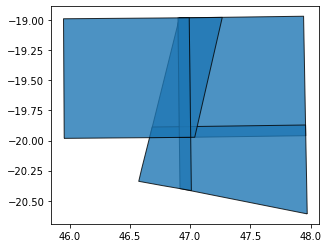

In [7]:
# Convert features to a GeoDataFrame
gdf = gpd.GeoDataFrame.from_features(data['features'])

# Plot the footprints of each dataset
gdf.plot(alpha=0.8, edgecolor='black')

If we print the GeoDataFrame itself, we can see that it contains useful metadata fields that provide information about each dataset:

In [8]:
gdf.head(1)

,geometry,title,gsd,created,updated,proj:epsg,platform,view:off_nadir,data_coverage,instruments,...,sentinel:utm_zone,sentinel:product_id,sentinel:grid_square,sentinel:data_coverage,sentinel:latitude_band,sentinel:valid_cloud_cover,proj:shape,proj:transform,datetime,cubedash:region_code
0,"POLYGON ((46.91100 -19.97450, 46.89992 -19.028...",S2B_MSIL2A_20200101T070219_N0213_R120_T38KQD_2...,10,2020-08-19T00:49:03.181000Z,2020-08-19T00:49:03.181Z,32738,sentinel-2b,0,99.97,[msi],...,38,S2B_MSIL2A_20200101T070219_N0213_R120_T38KQD_2...,QD,99.97,K,True,"[10980, 10980]","[10.0, 0.0, 699960.0, 0.0, -10.0, 7900000.0, 0...",2020-01-01T07:05:01Z,38KQD


We can use this to learn more about our data. For example, we can plot our datasets using the `eo:cloud_cover` field to show what percent of each dataset was obscured by cloud (yellow = high cloud cover):

<AxesSubplot:>

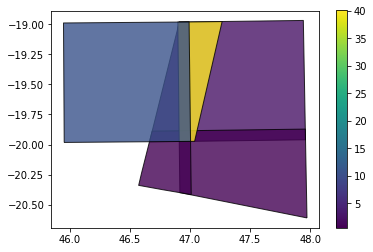

In [9]:
# Colour features by cloud cover
gdf.plot(column='eo:cloud_cover',
         cmap='viridis',
         alpha=0.8,
         edgecolor='black',
         legend=True)

## Inspecting assets
Each STAC Item listed in `features` can contain multiple `assets`. This assets represent unique data files or layers, for example individual remote sensing bands. For Digital Earth Africa's Sentinel-2 products, these can include the bands, metadata, etc.

In [10]:
stac_item = data['features'][0]
pprint(stac_item['assets'], depth=1)

{'AOT': {...},
 'B01': {...},
 'B02': {...},
 'B03': {...},
 'B04': {...},
 'B05': {...},
 'B06': {...},
 'B07': {...},
 'B08': {...},
 'B09': {...},
 'B11': {...},
 'B12': {...},
 'B8A': {...},
 'SCL': {...},
 'WVP': {...},
 'info': {...},
 'metadata': {...},
 'overview': {...},
 'thumbnail': {...},
 'visual': {...}}


Importantly, each asset (for example, `'B05'`) provides a unique URL (`href`) that can be used to access or download the data.
In this case, the `s3://` prefix indicates our data is stored in the cloud on Amazon S3.

In [11]:
pprint(stac_item['assets']['B05'])

{'eo:bands': [{'name': 'B05'}],
 'href': 's3://deafrica-sentinel-2/sentinel-s2-l2a-cogs/38/K/QD/2020/1/S2B_38KQD_20200101_0_L2A/B05.tif',
 'proj:epsg': 32738,
 'proj:shape': [5490, 5490],
 'proj:transform': [20.0, 0.0, 699960.0, 0.0, -20.0, 7900000.0, 0.0, 0.0, 1.0],
 'roles': ['data'],
 'title': 'B05',
 'type': 'image/tiff; application=geotiff; profile=cloud-optimized'}


## Downloading files using STAC
Now that we have a URL, we can use this to download data to our local disk. 
For example, we may want to download data for the `'B05'` satellite band in our STAC Item. 
We can do this using the `s3_download` function from `odc.aws`:

In [12]:
# Get URL then download
url = stac_item['assets']['B05']['href']
odc.aws.s3_download(url)

'B05.tif'

To verify that this file downloaded correctly, we can load it into our notebook as an `xarray.Dataset()` using `rioxarray.open_rasterio`:

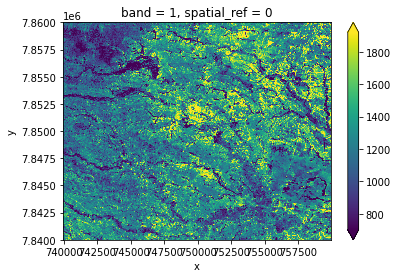

In [13]:
# Load data as an xarray.Dataset()
downloaded_ds = rioxarray.open_rasterio('B05.tif')

# Plot a small subset of the data
downloaded_ds.isel(x=slice(2000, 3000), y=slice(2000, 3000)).plot(robust=True)

> **Note**: If this notebook is being run on the DE Africa Sandbox, the saved file will appear in the `Frequently_used_code` directory in the JupyterLab File Browser. 
To save it to your local PC, right click on the file and click `Download`. 

### Downloading multiple files
To download data from the `'B05'` band for each of the six STAC Items returned by our search:

```
# Get list of all URLs for the 'B05' band
asset = 'B05'
urls = [stac_item['assets'][asset]['href'] for stac_item in data['features']]

# Download each URL
for url in urls:
    print(url)
    odc.aws.s3_download(url)
```

To download all available bands (i.e. `assets`) for a single STAC Item:
```
# Get list of all URLs for all assets in the first STAC Item
stac_item = data['features'][0]
urls = [asset['href'] for asset in stac_item['assets'].values()]

# Download each URL
for url in urls:
    print(url)
    odc.aws.s3_download(url)
```

## Streaming data without downloading
Due to the increasing size of satellite datasets, downloading data directly to your own local disk can be time-consuming and slow. 
Sometimes, it is better to stream data directly from the cloud without downloading it first. This can be particularly powerful for data that is stored in the [Cloud Optimised GeoTIFF (COG)](https://www.cogeo.org/) format which is optimised for efficiently streaming small chunks of an image at a time.

This section demonstrates how data can be streamed directly from the cloud into both Python and the [QGIS GIS software (v3.14)](https://qgis.org/en/site/).
As a first step, we need to convert our Amazon S3 URL (e.g. `s3://`) into HTTPS format (e.g. `https://`) so that it can be read more easily:

In [14]:
# Get URL 
url = stac_item['assets']['B05']['href']

# Get https URL
bucket, key = odc.aws.s3_url_parse(url)
https_url = f'https://deafrica-sentinel-2.s3.af-south-1.amazonaws.com/{key}'
https_url

'https://deafrica-sentinel-2.s3.af-south-1.amazonaws.com/sentinel-s2-l2a-cogs/38/K/QD/2020/1/S2B_38KQD_20200101_0_L2A/B05.tif'

### Streaming data into Python
To stream data directly from the cloud into an `xarray.Dataset()` format so it can be analysed in Python, we can supply the HTTPS URL above directly to the `rioxarray.open_rasterio` function:

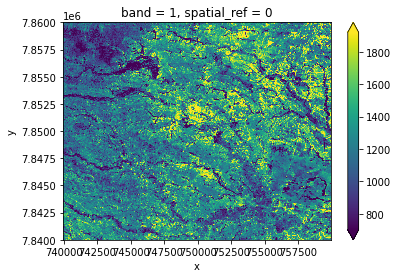

In [15]:
# Load data as an xarray.Dataset()
streamed_ds = rioxarray.open_rasterio(https_url)

# Plot a small subset of the data
streamed_ds.isel(x=slice(2000, 3000), y=slice(2000, 3000)).plot(robust=True)

### Streaming and reprojecting data
The code above will stream the entire dataset from the cloud into a `xarray.Dataset()`.
Sometimes, however, we may only want to stream a portion of large dataset into a spatial grid (e.g. resolution and coordinate reference system) that exactly matches data we have already loaded using Datacube. 

For example, we may have already used `dc.load` to load example data from the datacube into the  Africa Albers Equal Area Conic projection and a 5000 m pixel resolution:

In [16]:
# Load data from datacube
ds = dc.load(product='s2_l2a',
             time=('2020-01-01', '2020-01-31'),
             x=(46.8, 48.0),
             y=(-19.8, -19.4),
             resolution=(-5000, 5000),
             output_crs='epsg:6933',
             dask_chunks={})
ds

<xarray.Dataset>
Dimensions:      (time: 33, y: 11, x: 24)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-01T07:04:57 ... 2020-01-31T07:...
  * y            (y) float64 -2.428e+06 -2.432e+06 ... -2.472e+06 -2.478e+06
  * x            (x) float64 4.518e+06 4.522e+06 ... 4.628e+06 4.632e+06
    spatial_ref  int32 6933
Data variables: (12/15)
    B01          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    B02          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    B03          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    B04          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    B05          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    B06          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    ...           ...
    B09          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    B11          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    B12          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    AOT          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
    WVP          (time, y, x) uint16 dask.array<chunksize=(1, 11, 24), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref

We can now use the `rio_slurp_xarray` function to stream the data we identified using STAC into a format that is consistent with the `ds` data we loaded using the Datacube. 
Note that `gbox=ds.geobox` tells the function to load the data to match `ds`'s characteristics.
The output should therefore appear far more pixelated than previous plots:

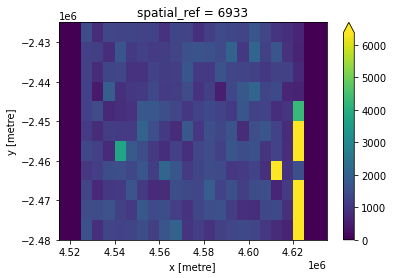

In [17]:
# Load data as an xarray.Dataset()
streamed_ds = rio_slurp_xarray(https_url, gbox=ds.geobox)

# Verify that data contains an Open Data Cube geobox
streamed_ds.plot(robust=True)

In [18]:
ds.geobox == streamed_ds.geobox

True

> **Note:** For more about reprojecting data, see the [Reprojecting datacube and raster data](Reprojecting_data.ipynb) notebook.

### Streaming data into QGIS

To stream data directly into a GIS software like QGIS without having to download it, first select and copy the HTTPS URL above (e.g. `'https://dea-public-data...`) to our clipboard, then open QGIS. In QGIS, click `Layer > Add Layer > Add Raster Layer`:

![](../Supplementary_data/Downloading_data_with_STAC/qgis_stac_1.jpg)

On the `Data Source Manager | Raster` dialogue, click `Protocol: HTTP(S), cloud, etc`. Ensure `Type` is set to `HTTP/HTTPS/FTP`, and paste the URL you copied into the `URI` box:

![](../Supplementary_data/Downloading_data_with_STAC/qgis_stac_2.jpg)

Click `Add`, then `Close`. After a few moments, the image we identified using STAC will appear on the map. This data is being streamed directly from the cloud - no downloading required!

![](../Supplementary_data/Downloading_data_with_STAC/qgis_stac_3.jpg)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [19]:
print(datacube.__version__)

1.8.7


**Last Tested:**

In [20]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2022-06-17'